# Predicción de retorno de acciones

En este estudio de caso, se utiliza varios modelos basados en el aprendizaje supervisado para predecir el precio de las acciones de Microsoft utilizando activos correlacionados y sus propios datos históricos.

## Contenido

* [1. Definición del problema](#0)
* [2. Cargando Librerias y el conjunto de datos](#1)
    * [2.1. Cargando librerias](#1.1)    
    * [2.2. Cargando el conjunto de datos](#1.2)
* [3. Análisis de datos exploratorio](#2)
    * [3.1 Estadística descriptiva](#2.1)    
    * [3.2. Visualización de datos](#2.2)
    * [3.3. Análisis de la serie de tiempo](#2.3)
* [4. Preparación de datos](#3)
    * [4.1 Limpieza de datos](#3.1)    
    * [4.2.Selección de características](#3.2) 
* [5.Evaluar algoritmos y modelos](#4)        
    * [5.1. Dividir en Entrenamiento/Test](#4.1)
    * [5.2. Métricas de evaluación](#4.2)
    * [5.3. Comparar modelos y algoritmos](#4.3)
        * [5.3.1 Modelos de aprendizaje de máquina](#4.3.1)
        * [5.3.2 Series de tiempo basado en ARIMA](#4.3.2)
* [6. Ajuste de modelos y grilla de busqueda](#5)
* [7. Finalización](#6)
    * [7.1. Resultados en el conjunto de test](#6.1)
    * [7.2. Guardar el modelo](#6.2)     

<a id='0'></a>
# 1. Definición del problema

En el marco de regresión supervisada utilizado para este estudio de caso, el retorno semanal de las acciones de Microsoft son la variable a predecir. Necesitamos comprender qué afecta el precio de las acciones de Microsoft y, por lo tanto, incorporar tanta información en el modelo. 

Para este estudio de caso, además de los datos históricos de Microsoft, las variables independientes utilizadas son los siguientes activos potencialmente correlacionados:

* **Acciones**: IBM (IBM) y Alphabet (GOOGL)
* **Divisas**: USD/JPY y GBP/USD
* **Indices**: S&P 500, Dow Jones y VIX


<a id='1'></a>
# 2. Cargando Librerias y el conjunto de datos

<a id='1.1'></a>
## 2.1. Cargando librerias 

In [28]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import SGD
#from keras.layers import LSTM
#from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Cargando los datos

Ahora, se procederá a extraer los datos requeridos para el anáisis utilizando la libreria `pandas-datareader`

In [4]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

start = pd.to_datetime('1/1/2010')
end = pd.to_datetime('31/12/2019')

stk_data = web.DataReader(stk_tickers, 'yahoo', start, end)
ccy_data = web.DataReader(ccy_tickers, 'fred', start, end)
idx_data = web.DataReader(idx_tickers, 'fred', start, end)

A continuación se necesita una serie a predecir. La variable a predecir son los retornos semanales de la acción de Microsoft. Vamos a aproximarlo usando un periodo de 5 días laborales. 

In [5]:
return_period = 5

Ahora definamos la serie en X y la serie en Y

Y: MSFT retornos **Futuros**

X:

    a. GOOGL retorno de 5 días laborales
    b. IBM retorno de 5 días laborales   
    c. USD/JPY retorno de 5 días laborales    
    d. GBP/USD retorno de 5 días laborales    
    e. S&P 500 retorno de 5 días laboraless    
    f. Dow Jones retorno de 5 días laborales  
    g. MSFT 5 retorno de 5 días laborales
    h. MSFT 15 retorno de 5 días laborales    
    i. MSFT 30 retorno de 5 días laborales    
    j. MSFT 60 retorno de 5 días laborales

Eliminamos los rendimientos anteriores de MSFT cuando usamos los modelos de series temporales.

In [9]:
stk_data.head()

Attributes  Adj Close                             Close              \
Symbols          MSFT        IBM       GOOGL       MSFT         IBM   
Date                                                                  
2010-01-04  23.855654  84.331680  313.688690  30.950001  126.625237   
2010-01-05  23.863369  83.312943  312.307312  30.959999  125.095604   
2010-01-06  23.716915  82.771721  304.434448  30.770000  124.282982   
2010-01-07  23.470266  82.485245  297.347351  30.450001  123.852776   
2010-01-08  23.632132  83.312943  301.311310  30.660000  125.095604   

Attributes                   High                                Low  \
Symbols          GOOGL       MSFT         IBM       GOOGL       MSFT   
Date                                                                   
2010-01-04  313.688690  31.100000  127.122368  315.070068  30.590000   
2010-01-05  312.307312  31.100000  126.051628  314.234222  30.639999   
2010-01-06  304.434448  31.080000  125.707458  313.243256  30.520000   
2010-01-07  297.347351  30.700001  124.521988  305.305298  30.190001   
2010-01-08  301.311310  30.879999  125.162521  301.926941  30.240000   

Attributes                               Open                          \
Symbols            IBM       GOOGL       MSFT         IBM       GOOGL   
Date                                                                    
2010-01-04  125.095604  312.432434  30.620001  125.411087  313.788788   
2010-01-05  124.378586  311.081085  30.850000  125.889099  313.903900   
2010-01-06  124.101341  303.483490  30.879999  124.933075  313.243256   
2010-01-07  123.240921  296.621613  30.629999  124.158699  305.005005   
2010-01-08  123.374763  294.849854  30.280001  123.393883  296.296295   

Attributes      Volume                         
Symbols           MSFT        IBM       GOOGL  
Date                                           
2010-01-04  38409100.0  6438444.0   3908488.0  
2010-01-05  49749600.0  7156104.0   6003391.0  
2010-01-06  58182400.0  5863144.0   7949443.0  
2010-01-07  50559700.0  6109268.0  12815771.0  
2010-01-08  51197400.0  4390271.0   9439151.0

In [8]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name].asfreq('5B',method = 'pad')
X = dataset.loc[:, X.columns].asfreq('5B',method = 'pad')

<a id='2'></a>
# 3. Análisis de datos exploratorio

<a id='2.1'></a>
## 3.1. Estadística descriptiva

Miremos el conjunto de datos a utilizar

In [10]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.005283,0.004040,-0.000453,0.000767,-0.000398,0.002229,0.002044,-0.001600,0.004547,0.014039,0.026609,0.054500
std,0.029861,0.032491,0.028402,0.012738,0.012959,0.017932,0.017765,0.154663,0.031134,0.045132,0.060421,0.081798
min,-0.121352,-0.109252,-0.128395,-0.045286,-0.098355,-0.069230,-0.063244,-0.442047,-0.155140,-0.163793,-0.133148,-0.154349
25%,-0.008790,-0.014625,-0.014870,-0.006781,-0.007488,-0.006272,-0.006635,-0.096245,-0.011191,-0.010750,-0.009768,0.001948
50%,0.007575,0.006678,0.000799,0.001283,-0.000735,0.003542,0.003665,-0.016843,0.007321,0.015749,0.030233,0.062197
75%,0.022329,0.023630,0.016971,0.007831,0.007907,0.013643,0.013336,0.078737,0.022227,0.039563,0.061354,0.109219
max,0.116829,0.174223,0.092039,0.053004,0.037368,0.046191,0.047018,0.687228,0.116829,0.159235,0.209844,0.256370


In [11]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2012-05-11,-0.056032,0.013742,-0.014630,0.000250,-0.004220,-0.011541,-0.016836,0.037392,0.005793,-0.039640,-0.030344,0.036273
2012-05-18,-0.007201,-0.008012,-0.026648,-0.009057,-0.018326,-0.043932,-0.035829,0.232651,-0.056032,-0.082007,-0.067519,-0.062749
2012-05-25,-0.017706,-0.014884,-0.008099,0.006298,-0.008907,0.017298,0.006884,-0.142794,-0.007201,-0.057439,-0.051937,-0.098855
2012-06-05,0.026991,-0.041096,-0.037654,-0.011012,-0.017751,-0.035849,-0.036650,0.160043,-0.036167,-0.066816,-0.112684,-0.108628
2012-06-12,0.047016,-0.009353,0.027885,0.011012,0.013391,0.029646,0.036103,-0.110868,0.026991,-0.015583,-0.082574,-0.100526


<a id='2.2'></a>
## 3.2. Visualización de datos

A continuación, veamos la distribución de los datos durante todo el período.

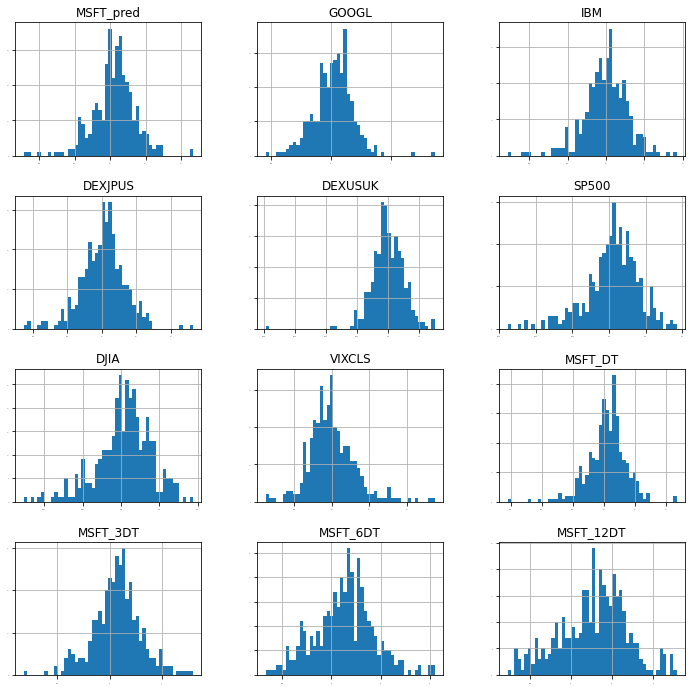

In [12]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

El histograma anterior muestra la distribución de cada serie individualmente. A continuación, veamos la distribución de densidad en la misma escala del eje x.

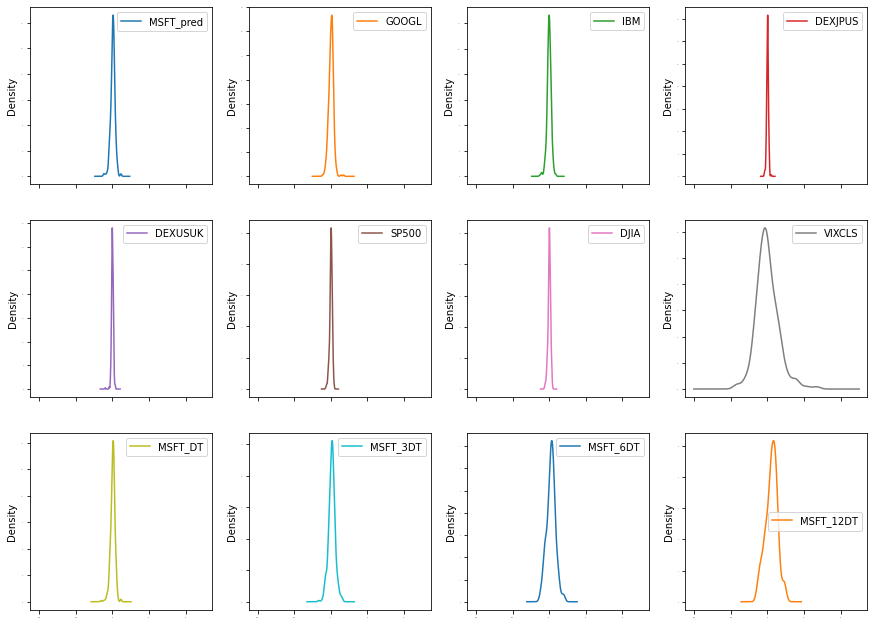

In [13]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Podemos ver que el VIX tiene una varianza mucho mayor en comparación con las otras distribuciones.

Para tener una idea de la interdependencia de los datos, observamos el diagrama de dispersión y la matriz de correlación.

<AxesSubplot:title={'center':'Correlation Matrix'}>

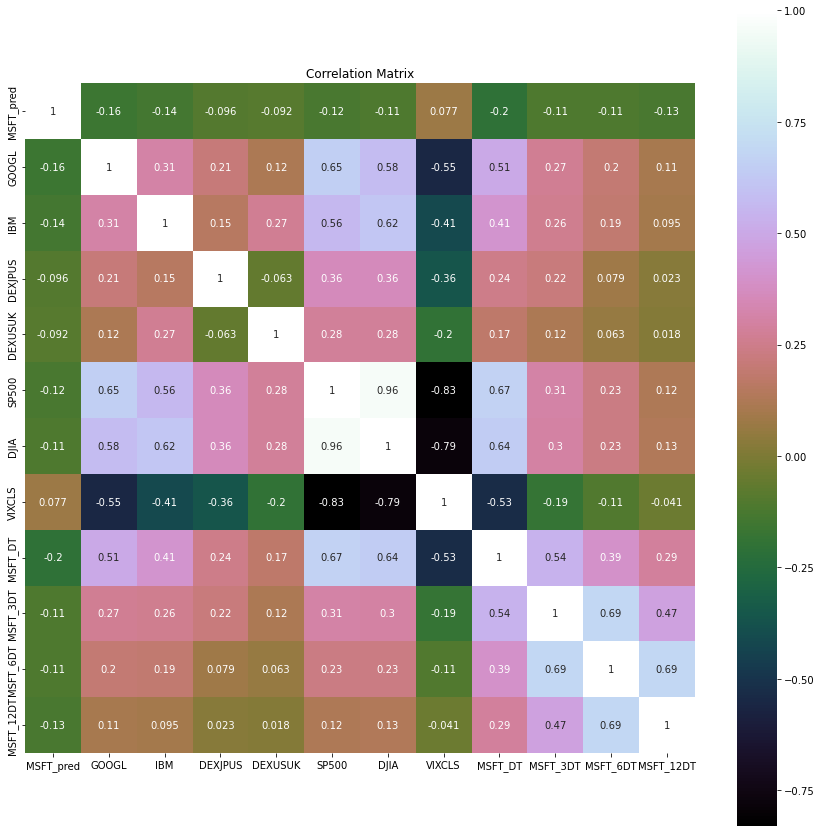

In [14]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Mirando el gráfico de correlación anterior, ¿qué se puede concluir?

<Figure size 1080x1080 with 0 Axes>

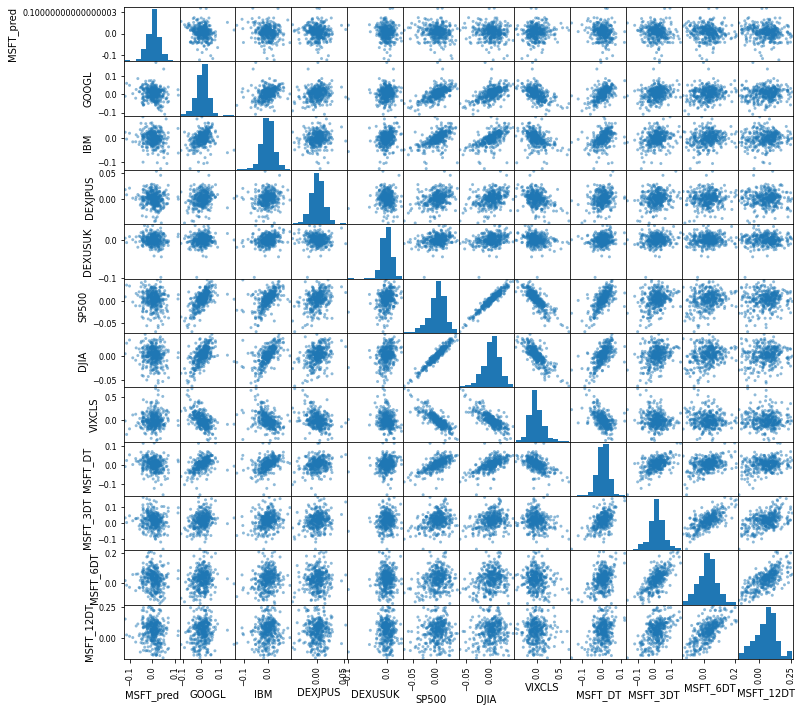

In [15]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Mirando el gráfico de dispersión anterior, ¿vemos alguna relación lineal de la variable predicha con otra variable?

<a id='2.3'></a>
## 3.3. Análisis de la serie de tiempo

A continuación, se observa la descomposición de nuestra serie temporal

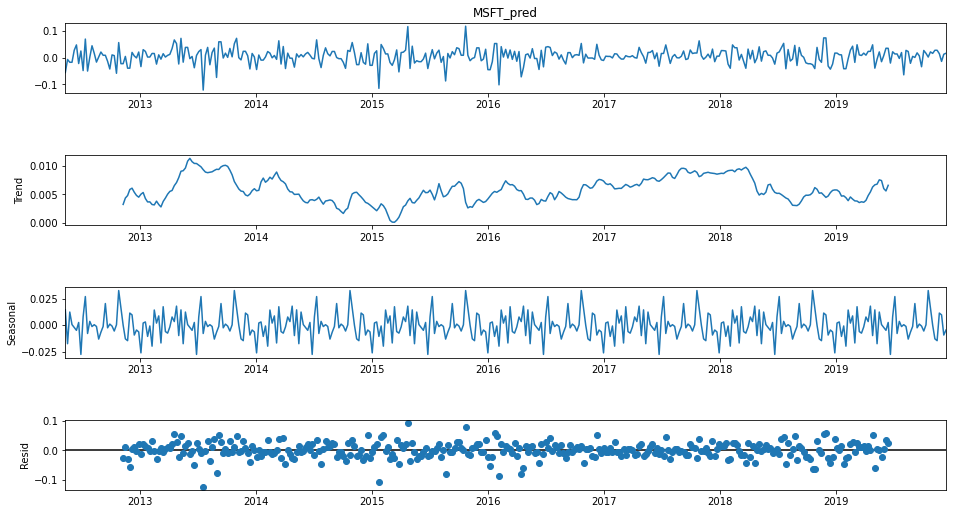

In [16]:
res = sm.tsa.seasonal_decompose(Y, model = "additive")
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Que se puede concluir de esta gráfica?

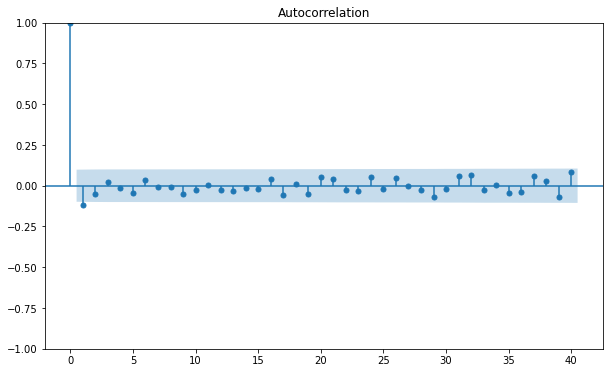

In [17]:
plt.rc("figure", figsize=(10,6))
plot_acf(Y, lags=40);
plt.show()

<a id='3'></a>
## 4. Preparación de los datos

<a id='3.2'></a>
## 4.2. Selección de características

Usamos la función SelectKBest de sklearn para tener una idea de la importancia de las características

In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,20.509799
IBM,10.837248
GOOGL,9.519350
SP500,6.548001
DJIA,5.933115
MSFT_3DT,5.302340
MSFT_12DT,5.160522
DEXJPUS,4.719397
MSFT_6DT,3.136473


Cuál de estas características es de las más importantes?

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

<a id='4.1'></a>
## 5.1. Dividir el conjunto en entrenamiento y test

A continuación, comenzamos dividiendo nuestros datos en conjunto de entrenamiento y test. Si vamos a utilizar modelos de series temporales, tenemos que dividir los datos en series continuas.

In [19]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Métricas de evaluación

In [20]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Comparación de modelos y algoritmos

<a id='4.3.1'></a>
### 5.3.1 Modelos de aprendizaje de máquina

##### Algoritmos de regresión y regresión de árbol

In [21]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Algoritmos basados en redes neuronales

In [22]:
models.append(('MLP', MLPRegressor()))

##### Ensamble de modelos

In [23]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Una vez que hemos seleccionado todos los modelos, hacemos un loop sobre cada uno de ellos. Primero ejecutamos el análisis de K-fold. A continuación, ejecutamos el modelo en todo el conjunto de datos de entrenamiento y prueba.

In [29]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    kfold = TimeSeriesSplit(n_splits = num_folds)

    # Converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001054 (0.000516) 0.000824 0.000709
LASSO: 0.000898 (0.000432) 0.000902 0.000760
EN: 0.000898 (0.000432) 0.000902 0.000760
KNN: 0.001150 (0.000386) 0.000696 0.000997
CART: 0.001963 (0.000540) 0.000000 0.002722
SVR: 0.001311 (0.000635) 0.000969 0.000910
MLP: 0.001984 (0.001094) 0.001411 0.001300
ABR: 0.001072 (0.000398) 0.000599 0.001044
GBR: 0.001124 (0.000425) 0.000176 0.001054
RFR: 0.000992 (0.000362) 0.000120 0.000921
ETR: 0.000979 (0.000362) 0.000000 0.000968


#### Resultados de K Fold 

Estamos mirando los resultados de K Fold

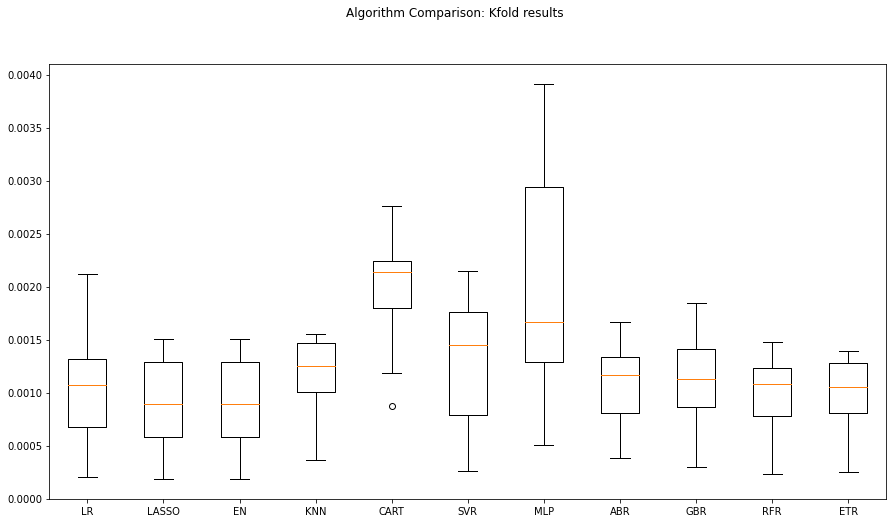

In [30]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Vemos que la regresión lineal y la regresión regularizada, incluida la regresión de Lasso (LASSO) y la red elástica (EN), parecen hacer un buen trabajo.

#### Error en entrenamiento y test

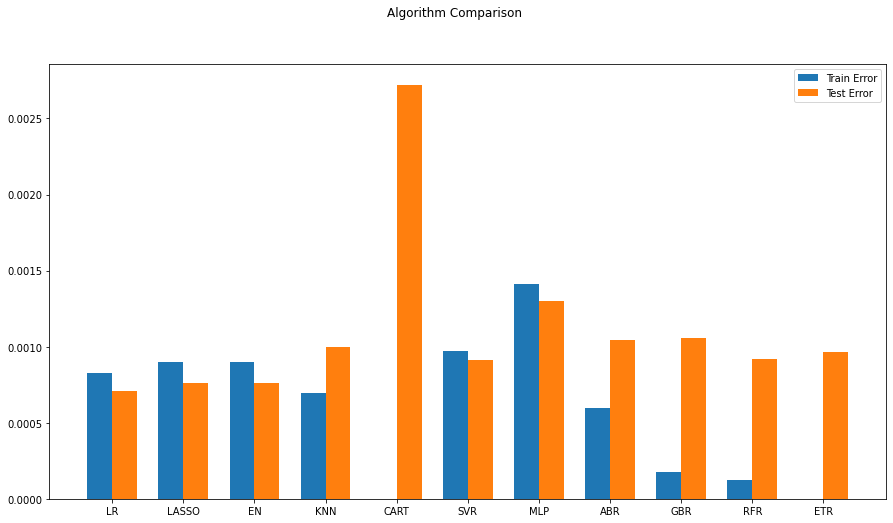

In [31]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Mirando el error de entrenamiento y test, aún vemos un mejor desempeño de los modelos lineales. Algunos de los algoritmos, como el regresor del árbol de decisión (CART), se sobreajustaron en los datos de entrenamiento y produjeron un error muy alto en el conjunto de prueba, por lo que estos modelos deben evitarse. Los modelos de ensamble, como la regresión de aumento de gradiente (GBR) y la regresión de bosque aleatorio (RFR) tienen un sesgo bajo (low bias) pero una varianza alta (high variance) (sobreajuste). También vemos que el algoritmo de la red neuronal artificial (que se muestra como MLP es el gráfico) muestra errores más altos tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que quizás se deba a la relación lineal de las variables que ANN no capturó con precisión o hiperparámetros inadecuados o entrenamiento insuficiente del modelo

<a id='4.3.1'></a>
### 5.3.1 Series de tiempo basado en ARIMA

Primero preparemos el conjunto de datos para los modelos ARIMA, teniendo solo las variables correlacionadas como variables exógenas.

### Modelo en series de tiempo - Modelo ARIMA 

In [32]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [34]:
modelARIMA=ARIMA(endog = Y_train, exog = X_train_ARIMA, order=(1,0,0))
model_fit = modelARIMA.fit()

In [35]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0007161597029002784

#### Añadir los nuevos resultados

In [36]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append("ARIMA")

## Comparación de todos los algoritmos de forma general

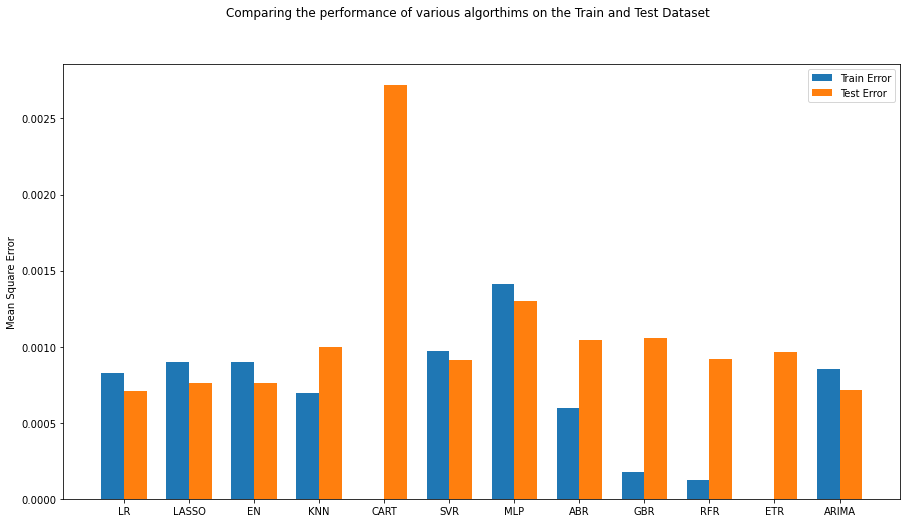

In [37]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Mirando el gráfico anterior, encontramos un modelo ARIMA basado en series de tiempo comparable a los modelos de regresión lineal supervisada como Linear Regression (LR), Lasso Regression (LASSO) y Elastic Net (EN). Esto puede deberse principalmente a la fuerte relación lineal como se discutió anteriormente. Por lo tanto, seleccionamos el modelo ARIMA para el ajuste del modelo.

<a id='5'></a>
# 6. Ajuste de modelos y grilla de busqueda

Como se muestra en el gráfico anterior, el modelo ARIMA es uno de los mejores, por lo que realizamos el ajuste del modelo ARIMA. El orden predeterminado del modelo ARIMA es [1,0,0]. Realizamos una búsqueda en cuadrícula con diferentes combinaciones p, d y q en el orden del modelo ARIMA.

In [38]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0008592
ARIMA(0, 0, 1) MSE=0.0008558
ARIMA(0, 0, 2) MSE=0.0008555
ARIMA(0, 1, 0) MSE=0.0016520
ARIMA(0, 1, 1) MSE=0.0009006
ARIMA(0, 1, 2) MSE=0.0009214
ARIMA(0, 2, 0) MSE=0.0045968
ARIMA(0, 2, 1) MSE=0.0016965
ARIMA(0, 2, 2) MSE=0.0009674
ARIMA(1, 0, 0) MSE=0.0008560
ARIMA(1, 0, 1) MSE=0.0008557
ARIMA(1, 0, 2) MSE=0.0008556
ARIMA(1, 1, 0) MSE=0.0013155
ARIMA(1, 1, 1) MSE=0.0009174
ARIMA(1, 1, 2) MSE=0.0008924
ARIMA(1, 2, 0) MSE=0.0028879
ARIMA(1, 2, 1) MSE=0.0013986
ARIMA(1, 2, 2) MSE=0.0015666
ARIMA(2, 0, 0) MSE=0.0008555
ARIMA(2, 0, 1) MSE=0.0008558
ARIMA(2, 0, 2) MSE=0.0008550
ARIMA(2, 1, 0) MSE=0.0011534
ARIMA(2, 1, 1) MSE=0.0009396
ARIMA(2, 1, 2) MSE=0.0008902
ARIMA(2, 2, 0) MSE=0.0021988
ARIMA(2, 2, 1) MSE=0.0012432
ARIMA(2, 2, 2) MSE=0.0013564
ARIMA(3, 0, 0) MSE=0.0008553
ARIMA(3, 0, 1) MSE=0.0008553
ARIMA(3, 0, 2) MSE=0.0008553
ARIMA(3, 1, 0) MSE=0.0010757
ARIMA(3, 1, 1) MSE=0.0009483
ARIMA(3, 1, 2) MSE=0.0008868
ARIMA(3, 2, 0) MSE=0.0017908
ARIMA(3, 2, 1)

<a id='6'></a>
# 7. Finalización

<a id='6.1'></a>
## 7.1. Resultados en el conjunto de test

In [39]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=(2,0,1))
model_fit_tuned = modelARIMA_tuned.fit()

In [40]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0007161597029002784


Después de ajustar el modelo y elegir el mejor modelo ARIMA, seleccionamos este modelo y se puede utilizar para fines de modelado.

<a id='6.2'></a>
## 7.2. Guardar el modelo

In [41]:
# Save Model Using Pickle
import pickle as pkl

# save the model to disk
filename = './data/finalized_model.sav'
pkl.dump(model_fit_tuned, open(filename, 'wb'))

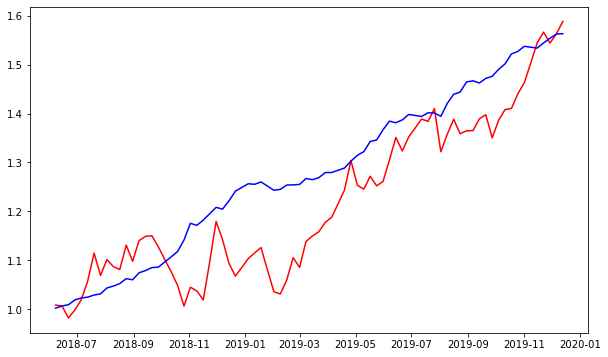

In [42]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

### Resumen

Podemos concluir que los modelos simples (regresión lineal, regresión regularizada (es decir, Lasso y red elástica)) junto con el modelo de serie temporal como ARIMA son enfoques de modelado prometedores para el problema de predicción de precios de activos. Estos modelos pueden permitir a los profesionales financieros modelar dependencias de tiempo con un enfoque muy flexible. El enfoque general presentado en este estudio de caso puede ayudarnos a encontrar sobreajuste y desajuste, que son algunos de los desafíos clave en la predicción.

También debemos tener en cuenta que podemos usar un mejor conjunto de indicadores, como la relación P/E, el volumen de negociación, los indicadores técnicos o los datos de noticias, lo que podría conducir a mejores resultados.

En general, creamos un marco de modelado de series de tiempo y regresión supervisada que nos permite realizar predicciones de clases de activos utilizando datos históricos para generar resultados y analizar el riesgo.
